# Lyrics detector Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, our model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

## 1. Data Cleaning

Our dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [40]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been takin' the pain away I heard you was givin' your chain away That's kinda like givin' your fame away What's wrong with you? I sit in a box where the owners do A boss is a role that I've grown into I love you to death but I told you the truth
2,Drake,"I can't just be with you and only you Yeah, I got one, Virgil got one and that there is the only two Man, how many times have I shown improvement? How many nights I been (Woah) Swervin' them potholes Not tryna fuck up the wheels on the road, okay Funny how life goes He thought he was sick, now h..."
3,Drake,"Well, summer, all I did was rest, okay? And New Year's, all I did was stretch, okay? And Valentine's Day, I had sex, okay? We'll see what's 'bout to happen next Okay? Okay? Okay? We'll see what's 'bout to happen next Okay? Okay? Okay? We'll see what's 'bout to happen, ayy, ayy We'll see what's '..."
4,Drake,I'm makin' a change today The liquor been takin' the pain away I heard you was givin' your chain away That's kinda like givin' your fame away What's wrong with you? I sit in a box where the owners do A boss is a role that I've grown into I love you to death but I told you the truth I–
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol? Okay man, just make sure it's not wack."""
3971,Kanye West,"Then one day I just went ahead and played it, I wanted to play some songs, cause you know Cam was in the room, Young Guru, and Dame was in the room. So I played... actually it's a song that you'll never hear, but maybe I might use it. So, it's called 'Wow.' ""I go to Jacob with 25 thou, you go wi..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,"Like they still weren't looking at me like a rapper. And I'm sure Dame figured, 'Like man. If he do a whole album, if his raps is wack at least we can throw Cam on every song and save the album, you know. So uh Dame took me into the office, and he's like ""yo man, B, B, you don't want a brick, yo..."


❓ **Have a look at the verse index 18th**. 
- What do you observe?
- Clean verses from non standard characters using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/)

In [41]:
pd.options.display.max_colwidth = 300
print(data.iloc[18])

artist                                                                                                                            Drake
verse     Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I was down Now them diamonds for fun like damn Ayy, yeah
Name: 18, dtype: object


In [42]:
import re

In [43]:
def cleanUp(text):
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    return text

In [44]:
data['verse'] = data['verse'].apply(cleanUp)

In [45]:
data.head()

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been takin' the pain away I heard you was givin' your chain away That's kinda like givin' your fame away What's wrong with you? I sit in a box where the owners do A boss is a role that I've grown into I love you to death but I told you the truth
2,Drake,"I can't just be with you and only you Yeah, I got one, Virgil got one and that there is the only two Man, how many times have I shown improvement? How many nights I been (Woah) Swervin' them potholes Not tryna fuck up the wheels on the road, okay Funny how life goes He thought he was sick, now h..."
3,Drake,"Well, summer, all I did was rest, okay? And New Year's, all I did was stretch, okay? And Valentine's Day, I had sex, okay? We'll see what's 'bout to happen next Okay? Okay? Okay? We'll see what's 'bout to happen next Okay? Okay? Okay? We'll see what's 'bout to happen, ayy, ayy We'll see what's '..."
4,Drake,I'm makin' a change today The liquor been takin' the pain away I heard you was givin' your chain away That's kinda like givin' your fame away What's wrong with you? I sit in a box where the owners do A boss is a role that I've grown into I love you to death but I told you the truth I


❓ **Check if some verses are duplicated.** 
- It can be frequent in music lyrics.
- If so, remove them to avoid data leaks between train and test sets

In [46]:
data["verse"].drop_duplicates(inplace=True)

In [47]:
data.shape

(3975, 2)

In [48]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Data Analysis (given to you)

👉 **We check the number of unique artist and the number of verses per artist**

In [49]:
data.artist.value_counts()

Drake         1690
Ed Sheeran    1405
Kanye West     880
Name: artist, dtype: int64

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

We'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [50]:
drake = data[data.artist =='Drake'].verse
ed = data[data.artist =='Ed Sheeran'].verse
kanye = data[data.artist =='Kanye West'].verse

In [51]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [52]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,i,i,i
2,you,you,the
3,the,the,you
4,and,and,to
5,to,me,and
6,a,to,a
7,it,my,my
8,me,a,it
9,i'm,in,me
10,my,i'm,in


👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- We compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

<details>
    <summary>Hints</summary>

We'll use Python [`set.intersection()`](https://www.programiz.com/python-programming/methods/set/intersection) and [`set.union()`](https://www.programiz.com/python-programming/methods/set/union)
</details>

In [53]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [54]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

15.12% of the artists' vocabulary is common


## 3. Data Preprocessing

### 3.1 Word Embedding
We now need to think about embedding our sentences into numbers. We will be using [`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**
- Store these sequences of words in a new column `data["seq"]` in your dataframe
- You can use `tensorflow.keras.preprocessing.text.text_to_word_sequence` 

In [55]:
data['seq'] = data['verse'].apply(tf.keras.preprocessing.text.text_to_word_sequence)

In [56]:
data.head()

,artist,verse,seq
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]"
1,Drake,I'm makin' a change today The liquor been takin' the pain away I heard you was givin' your chain away That's kinda like givin' your fame away What's wrong with you? I sit in a box where the owners do A boss is a role that I've grown into I love you to death but I told you the truth,"[i'm, makin', a, change, today, the, liquor, been, takin', the, pain, away, i, heard, you, was, givin', your, chain, away, that's, kinda, like, givin', your, fame, away, what's, wrong, with, you, i, sit, in, a, box, where, the, owners, do, a, boss, is, a, role, that, i've, grown, into, i, love, ..."
2,Drake,"I can't just be with you and only you Yeah, I got one, Virgil got one and that there is the only two Man, how many times have I shown improvement? How many nights I been (Woah) Swervin' them potholes Not tryna fuck up the wheels on the road, okay Funny how life goes He thought he was sick, now h...","[i, can't, just, be, with, you, and, only, you, yeah, i, got, one, virgil, got, one, and, that, there, is, the, only, two, man, how, many, times, have, i, shown, improvement, how, many, nights, i, been, woah, swervin', them, potholes, not, tryna, fuck, up, the, wheels, on, the, road, okay, funny..."
3,Drake,"Well, summer, all I did was rest, okay? And New Year's, all I did was stretch, okay? And Valentine's Day, I had sex, okay? We'll see what's 'bout to happen next Okay? Okay? Okay? We'll see what's 'bout to happen next Okay? Okay? Okay? We'll see what's 'bout to happen, ayy, ayy We'll see what's '...","[well, summer, all, i, did, was, rest, okay, and, new, year's, all, i, did, was, stretch, okay, and, valentine's, day, i, had, sex, okay, we'll, see, what's, 'bout, to, happen, next, okay, okay, okay, we'll, see, what's, 'bout, to, happen, next, okay, okay, okay, we'll, see, what's, 'bout, to, h..."
4,Drake,I'm makin' a change today The liquor been takin' the pain away I heard you was givin' your chain away That's kinda like givin' your fame away What's wrong with you? I sit in a box where the owners do A boss is a role that I've grown into I love you to death but I told you the truth I,"[i'm, makin', a, change, today, the, liquor, been, takin', the, pain, away, i, heard, you, was, givin', your, chain, away, that's, kinda, like, givin', your, fame, away, what's, wrong, with, you, i, sit, in, a, box, where, the, owners, do, a, boss, is, a, role, that, i've, grown, into, i, love, ..."


❓ **Let's check if we can cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function
- Does it seem reasonable to limit ourself to 300 words per verse later on? 

In [57]:
lyrics_len = [len(s) for s in data.seq]

/Users/dariarousset/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

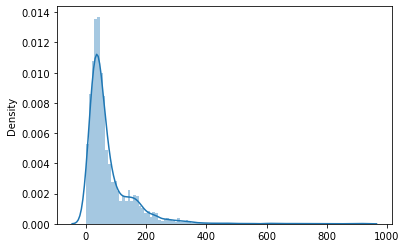

In [58]:
sns.distplot(lyrics_len, bins=100)

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

❓ **Train a `gensim.models.Word2Vec` model on your dataset** 
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [59]:
!pip install gensim==3.6.0

In [60]:
from gensim.models import Word2Vec

word2vec = Word2Vec(sentences=data.seq, size=100, min_count=10, window=10)

In [61]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences
data["embed"] = embedding(word2vec, data.seq)

In [62]:
# Check 
assert len(data['embed']) == len(data)

### 3.2 Create (X,y)

❓ **Create your numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [63]:
X = pad_sequences(data.embed, dtype='float32', padding='post', maxlen=300)

In [64]:
X.shape

(3975, 300, 100)

❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [65]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(data.artist)
print(integer_encoded)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

[0 0 0 ... 2 2 2]


In [66]:
y.shape

(3975, 3)

👉 We train/test split the dataset below for you

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [68]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

## 4. Recurrent Neural Network

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle
```

❓ **First, store your baseline accuracy to beat as `score_baseline`**
- Consider predicting always the most frequent artist

In [69]:
baseline_score = 1690/3975
baseline_score

0.42515723270440253

❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Keep it simple: use only one LSTM layer and one *hidden* dense layer between the input and output layers
- Don't forget to take care of fake "zeros" added during preprocessing
- Store it into the `model` variable.

In [70]:
# Note. Starting from here all training in collab because of "Dead Kernel" message

In [73]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

In [74]:
model = init_model()

❓ **Train your `model` on the `(X_train, y_train)` training set**
- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 3 minutes of training without GPUs.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

from tensorflow.keras import Sequential
from tensorflow.keras import layers

model = init_model()

history = model.fit(X_train, y_train, 
          batch_size = 32,
          epochs=30,
          validation_split=0.3,
          callbacks=[es]
         )

❓ **Plot the training and validation losses through training**

In [37]:
# Plot below your train/val loss history
def plot_training_curves(history, figsize=(12, 5)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'], loc='upper left')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'], loc='upper left')

    return fig

fig = plot_training_curves(history)

# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

❓ **Save your accuracy on test set as `score_test`**

In [40]:
res = model.evaluate(X_test, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

In [75]:
score_test = 0.654

🧪 **Send your results below**

In [76]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()

AttributeError: 'Sequential' object has no attribute '_nested_inputs'